In [1]:
from scipy import stats
from scipy.stats import norm, skew 

import plotly_express as px
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("D:/myprograms/HousePrice/train.csv")
test_df = pd.read_csv("D:/myprograms/HousePrice/test.csv")

full_df=pd.concat([train_df,test_df],ignore_index=True,sort=False)

In [3]:
#设置多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# 探索性分析

## 数据概览

In [4]:
train_df.shape;test_df.shape

(1460, 81)

(1459, 80)

训练集和测试集数据量差不多，没有样本不平衡的问题。总共80个特征，特征数量较多。

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

阅读数据说明，特征中包含：<br />
建筑年份、售卖年份等时间序列数据<br />
评价质量好坏（有顺序）的类目型数据<br />
所属地区、风格、类别等（没有顺序）的类目型数据<br />
面积大小 等数值型数据<br />
有若干特征存在相关关系，如泳池、地下室<br />
考虑能否生成新的特征

## 目标变量的统计信息

In [6]:
train_df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
import plotly_express as px

px.histogram(train_df, x="SalePrice", histfunc="count", title='房屋售价直方图')

In [8]:
#目标变量的偏度和峰度
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


目标变量的分布情况，非正态分布，右偏。因为（线性）模型偏好正态分布，所以后面对Y取对数让其趋近正态分布。

In [9]:
#取对数后趋近正态分布了
SalePrice_log=pd.DataFrame(np.log(full_df['SalePrice']))
px.histogram(SalePrice_log,x="SalePrice", histfunc="count")

## 数值型特征与目标的关系

In [10]:
#数值型变量的统计信息
pd.set_option('display.max_columns', 38)
full_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235   
std       1.113131    30.291442     20.894344   179.334253   455.610826   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1953.500000   1965.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1993.000000     0.000000   368.500000   
75%       6.000000  2001.000000   2004.000000   164.000000   733.000000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  2918.000000  2918.000000  2918.000000  2919.000000  2919.000000   
mean     49.582248   560.772104  1051.777587  1159.581706   336.483727   
std     169.205611   439.543659   440.766258   392.362079   428.701456   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   220.000000   793.000000   876.000000     0.000000   
50%       0.000000   467.000000   989.500000  1082.000000     0.000000   
75%       0.000000   805.500000  1302.000000  1387.500000   704.000000   
max    1526.000000  2336.000000  6110.000000  5095.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   2919.000000  2919.000000   2917.000000   2917.000000  2919.000000   
mean       4.694416  1500.759849      0.429894      0.061364     1.568003   
std       46.396825   506.051045      0.524736      0.245687     0.552969   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1126.000000      0.000000      0.000000     1.000000   
50%        0.000000  1444.000000      0.000000      0.000000     2.000000   
75%        0.000000  1743.500000      1.000000      0.000000     2.000000   
max     1064.000000  5642.000000      3.000000      2.000000     4.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  2919.000000   2919.000000   2919.000000   2919.000000  2919.000000   
mean      0.380267      2.860226      1.044536      6.451524     0.597122   
std       0.502872      0.822693      0.214462      1.569379     0.646129   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     15.000000     4.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  2760.000000  2918.000000  2918.000000  2919.000000  2919.000000   
mean   1978.113406     1.766621   472.874572    93.709832    47.486811   
std      25.574285     0.761624   215.394815   126.526589    67.575493   
min    1895.000000     0.000000     0.000000     0.000000     0.000000   
25%    1960.000000     1.000000   320.000000     0.000000     0.000000   
50%    1979.000000     2.000000   480.000000     0.000000    26.000000   
75%    2002.000000     2.000000   576.000000   168.000000    70.000000   
max    2

In [11]:
#相关系数
Corr = train_df.corr()
Corr[Corr['SalePrice']>0.5].sort_values(by='SalePrice',ascending=False)

Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
SalePrice    -0.021917   -0.084284     0.351799  0.263843     0.790982   
OverallQual  -0.028365    0.032628     0.251646  0.105806     1.000000   
GrLivArea     0.008273    0.074853     0.402797  0.263116     0.593007   
GarageCars    0.016570   -0.040110     0.285691  0.154871     0.600671   
GarageArea    0.017634   -0.098672     0.344997  0.180403     0.562022   
TotalBsmtSF  -0.015415   -0.238518     0.392075  0.260833     0.537808   
1stFlrSF      0.010496   -0.251758     0.457181  0.299475     0.476224   
FullBath      0.005587    0.131608     0.198769  0.126031     0.550600   
TotRmsAbvGrd  0.027239    0.040380     0.352096  0.190015     0.427452   
YearBuilt    -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd -0.021998    0.040581     0.088866  0.013788     0.550684   

              OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
SalePrice       -0.077856   0.522897      0.507101    0.477493    0.386420   
OverallQual     -0.091932   0.572323      0.550684    0.411876    0.239666   
GrLivArea       -0.079686   0.199010      0.287389    0.390857    0.208171   
GarageCars      -0.185758   0.537850      0.420622    0.364204    0.224054   
GarageArea      -0.151521   0.478954      0.371600    0.373066    0.296970   
TotalBsmtSF     -0.171098   0.391452      0.291066    0.363936    0.522396   
1stFlrSF        -0.144203   0.281986      0.240379    0.344501    0.445863   
FullBath        -0.194149   0.468271      0.439046    0.276833    0.058543   
TotRmsAbvGrd    -0.057583   0.095589      0.191740    0.280682    0.044316   
YearBuilt       -0.375983   1.000000      0.592855    0.315707    0.249503   
YearRemodAdd     0.073741   0.592855      1.000000    0.179618    0.128451   

              BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
SalePrice      -0.011378   0.214479     0.613581  0.605852  0.319334   
OverallQual    -0.059119   0.308159     0.537808  0.476224  0.295493   
GrLivArea      -0.009640   0.240257     0.454868  0.566024  0.687501   
GarageCars     -0.038264   0.214175     0.434585  0.439317  0.183926   
GarageArea     -0.018227   0.183303     0.486665  0.489782  0.138347   
TotalBsmtSF     0.104810   0.415360     1.000000  0.819530 -0.174512   
1stFlrSF        0.097117   0.317987     0.819530  1.000000 -0.202646   
FullBath       -0.076444   0.288886     0.323722  0.380637  0.421378   
TotRmsAbvGrd   -0.035227   0.250647     0.285573  0.409516  0.616423   
YearBuilt      -0.049107   0.149040     0.391452  0.281986  0.010308   
YearRemodAdd   -0.067759   0.181133     0.291066  0.240379  0.140024   

              LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
SalePrice        -0.025606   0.708624      0.227122     -0.016844  0.560664   
OverallQual      -0.030429   0.593007      0.111098     -0.040150  0.550600   
GrLivArea         0.134683   1.000000      0.034836     -0.018918  0.630012   
GarageCars       -0.094480   0.467247      0.131881     -0.020891  0.469672   
GarageArea       -0.067601   0.468997      0.179189     -0.024536  0.405656   
TotalBsmtSF      -0.033245   0.454868      0.307351     -0.000315  0.323722   
1stFlrSF         -0.014241   0.566024      0.244671      0.001956  0.380637   
FullBath         -0.000710   0.630012     -0.064512     -0.054536  1.000000   
TotRmsAbvGrd      0.131185   0.825489     -0.053275     -0.023836  0.554784   
YearBuilt        -0.183784   0.199010      0.187599     -0.038162  0.468271   
YearRemodAdd     -0.062419   0.287389      0.119470     -0.012337  0.439046   

              HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
SalePrice     0.284108      0.168213     -0.135907      0.533723    0.466929   
OverallQual   0.273458      0.101676     -0.183882      0.427452    0.396765   
GrLivArea     0.415772      0.521270      0.100063      0.825489    0.461679   
GarageCars    0.219178      0.086106     -0.050634      0.36

与目标变量相关性大于0.5的数值型变量：<br />
OverallQual 整体质量，离散数值型<br />
GrLivArea 地面以上居住面积平方英尺，连续数值型<br />
GarageCars 车库容量的大小，离散数值型<br />
GarageArea 车库面积(平方英尺)<br />
TotalBsmtSF 地下室面积的总面积，连续数值型<br />
1stFlrSF 1楼面积，连续<br />
FullBath 浴室数量，离散<br />
TotRmsAbvGrd 房间数量，离散<br />
YearBuilt 建筑年份<br />
YearRemodAdd 改型日期(如果没有改型或添加，则与施工日期相同)

(<Figure size 864x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xeb02518>)

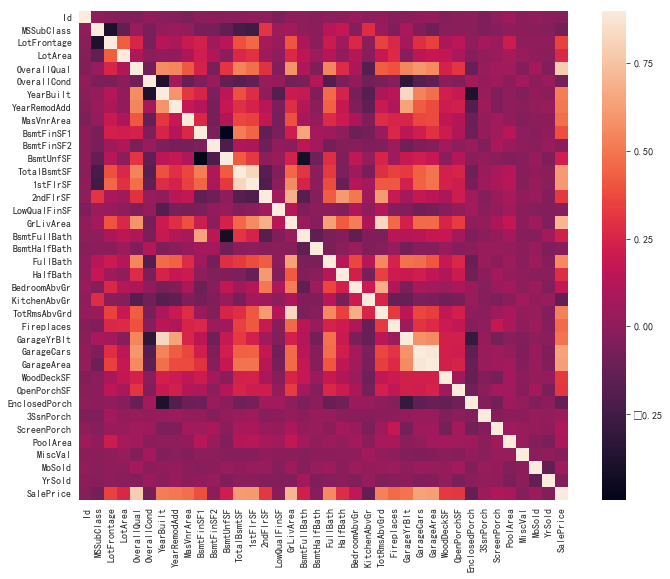

In [12]:
#相关图（热力图）
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,9))
sns.heatmap(Corr, vmax=0.9, square=True)

TotalBsmtSF和1stFirSF、GarageCars和GarageArea的相关性很高。

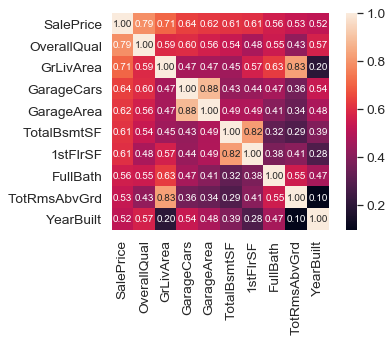

In [13]:
#与目标变量相关性最强的10个特征
cols = Corr.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

D:\Anaconda2\envs\py3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



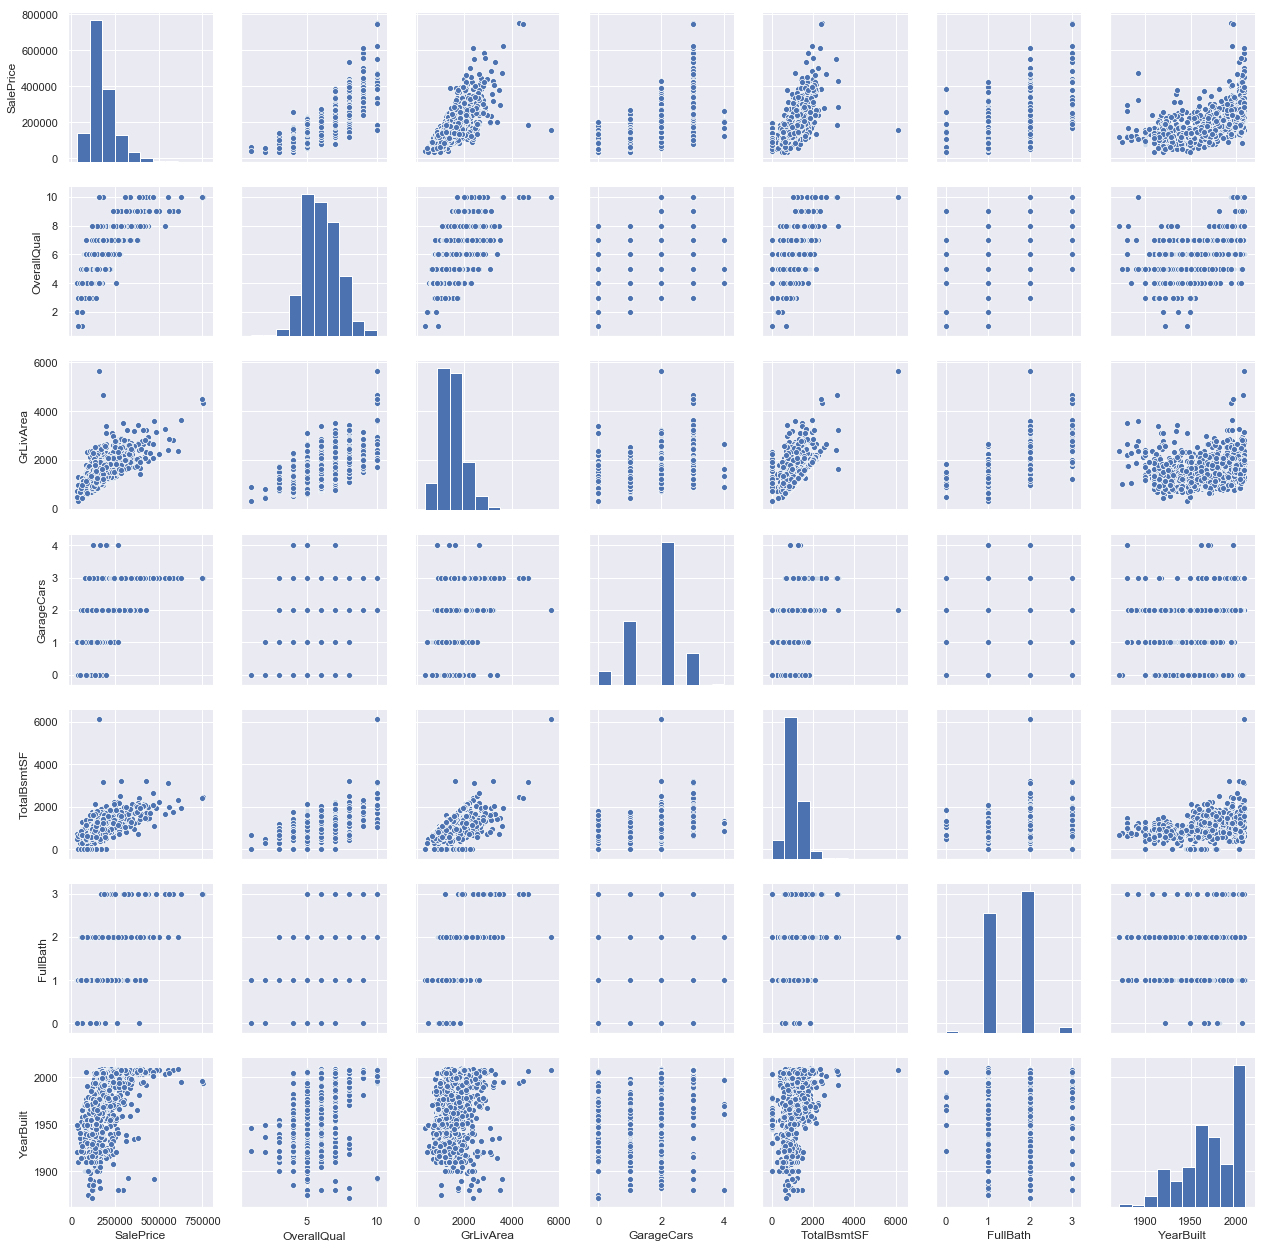

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

## 类目型特征和目标的关系

In [15]:
#查看类目型变量的唯一值有几个，考虑后续one-hot编码
full_objectinfo=full_df.describe(include = 'O')
full_objectinfo.loc['unique',:]

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
Name: unique, dtype: object

In [16]:
pd.set_option('display.max_columns', 43) #设置最大输出列数
full_objectinfo

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      2915   2919   198     2919        2919      2917      2919   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       2265   2907   120     1859        2622      2916      2133   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       2919         2919       2919       2919     2919       2919   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        2778          443       2511       2889     2425       1471   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       2919     2919        2918        2918       2895      2919   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        2310     2876        1025        1014       1742      1798   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       2919       2919     2838     2837         2837         2840   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        2538       1308     1283     2606         1904          851   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          2839    2919      2919       2919       2918        2918   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           2493    2874      1493       2723       2671        1492   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        2917        1499       2762         2760       2760       2760   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         2717         744       1723         1230       2604       2654   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        2919     10    571         105     2918          2919  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         2641      4    329          95     2525          2402

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'MSZoning 与房屋售价')

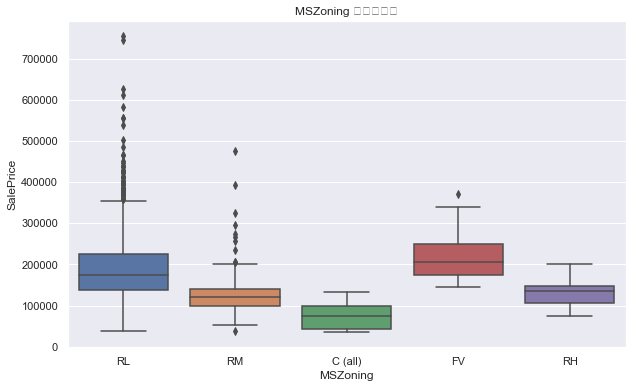

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Street 与房屋售价')

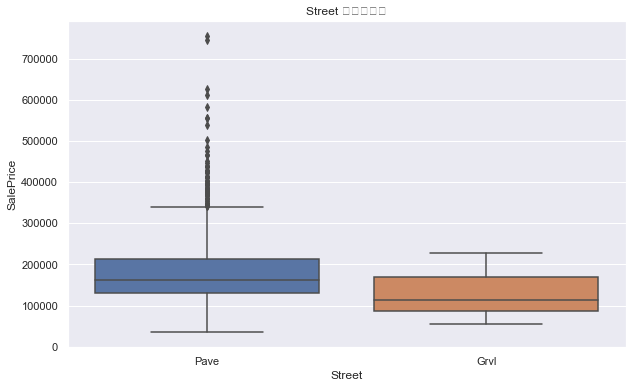

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Alley 与房屋售价')

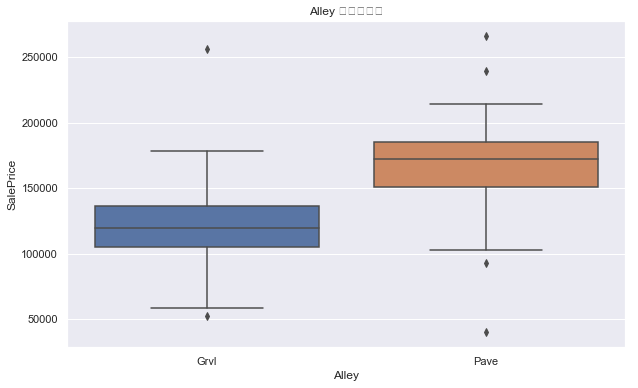

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'LotShape 与房屋售价')

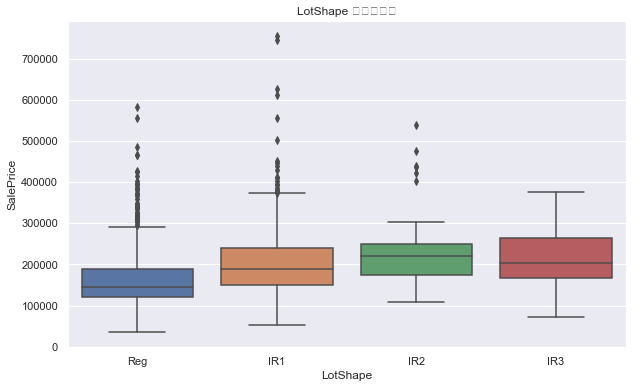

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'LandContour 与房屋售价')

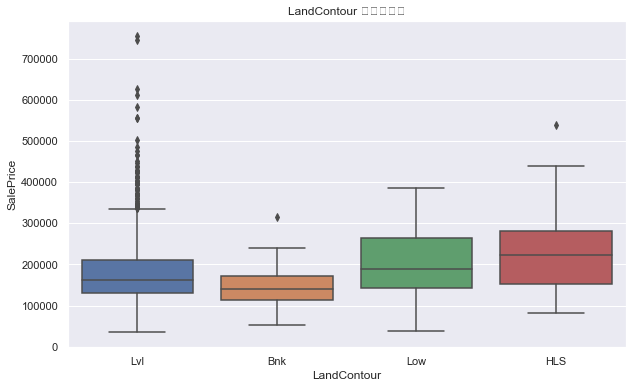

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Utilities 与房屋售价')

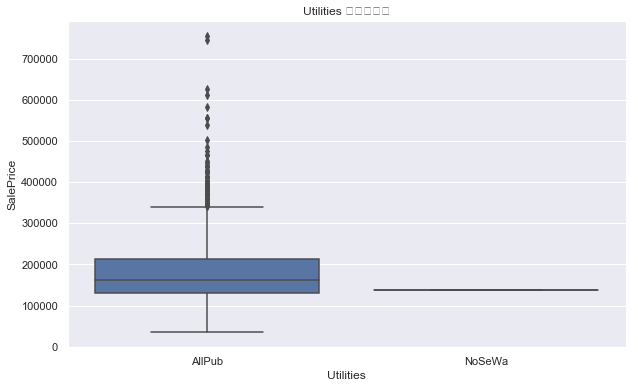

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'LotConfig 与房屋售价')

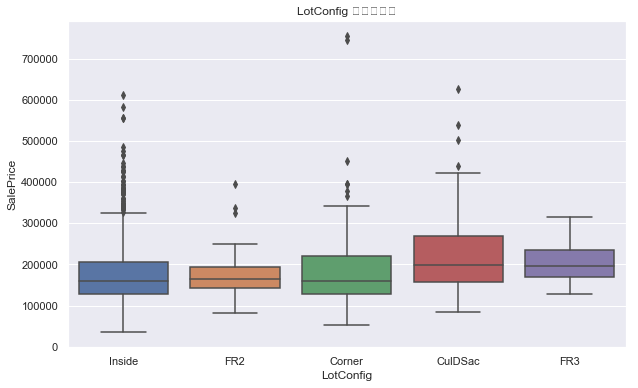

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'LandSlope 与房屋售价')

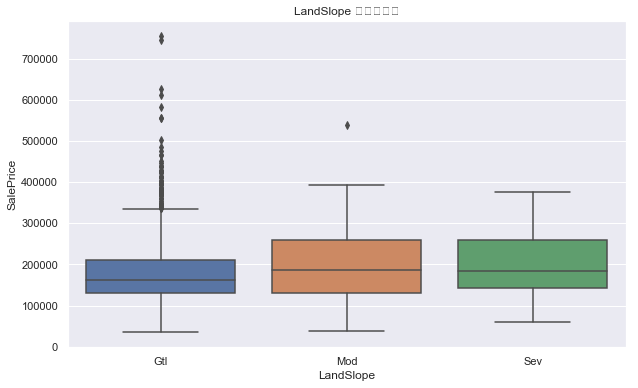

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Neighborhood 与房屋售价')

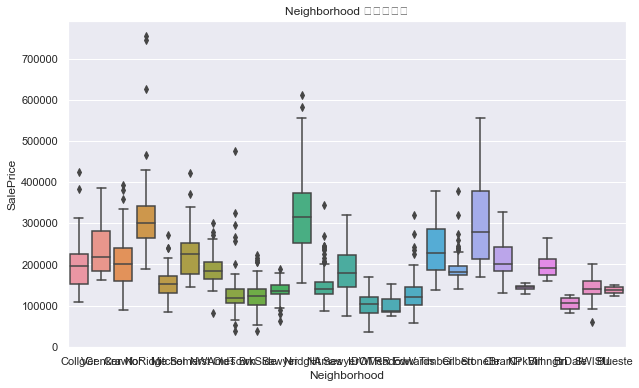

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Condition1 与房屋售价')

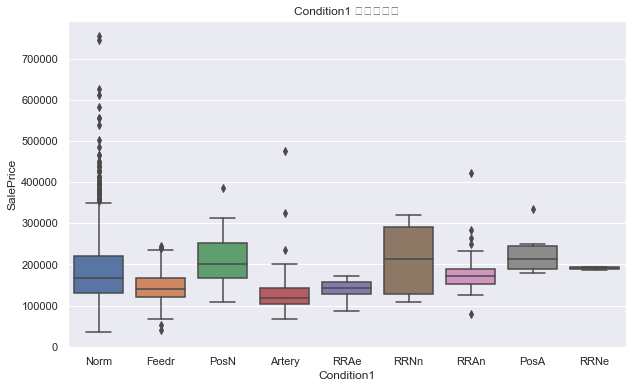

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Condition2 与房屋售价')

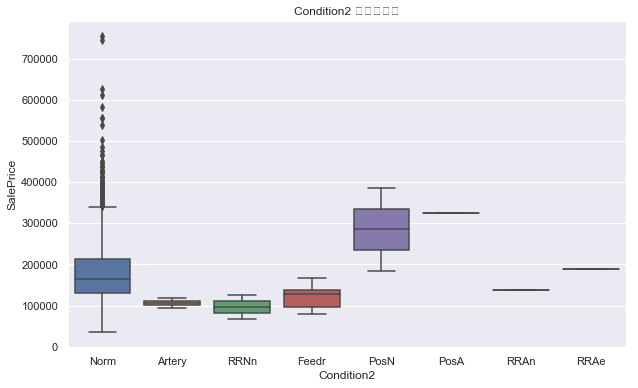

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'BldgType 与房屋售价')

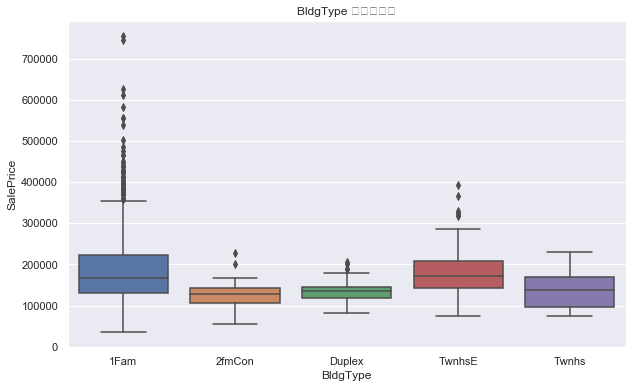

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'HouseStyle 与房屋售价')

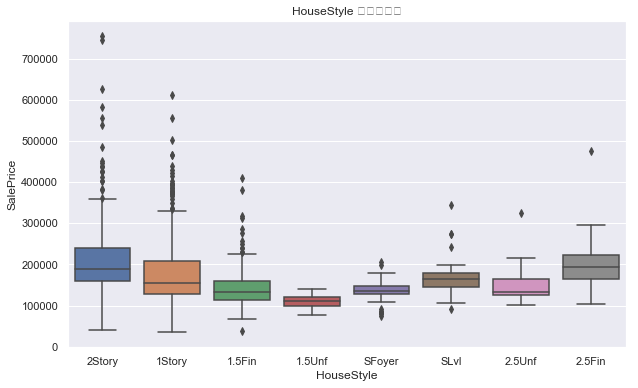

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'RoofStyle 与房屋售价')

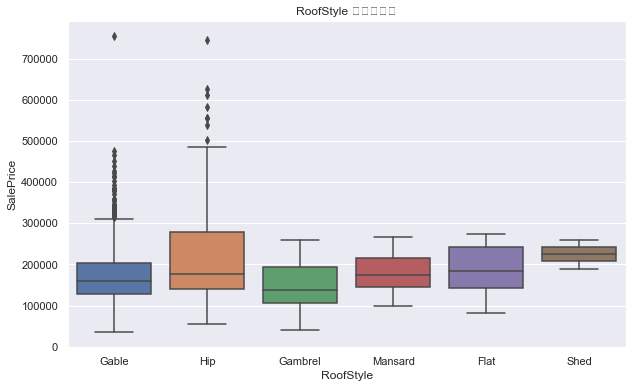

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'RoofMatl 与房屋售价')

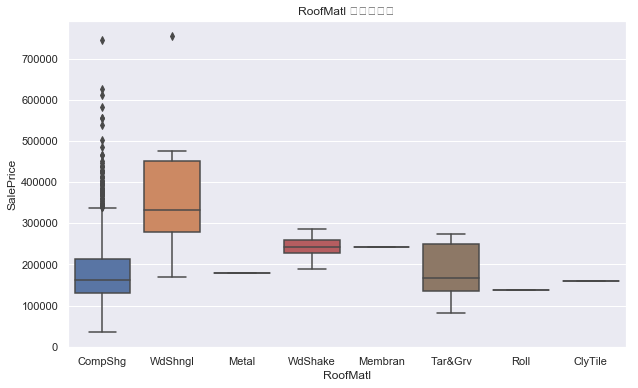

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Exterior1st 与房屋售价')

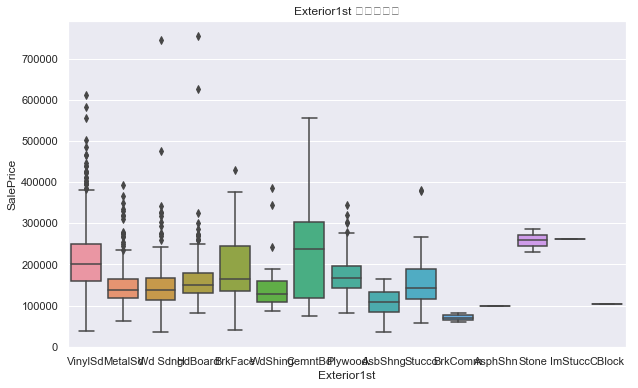

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Exterior2nd 与房屋售价')

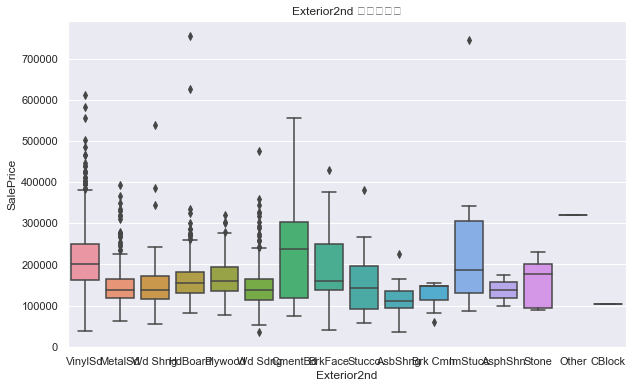

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'MasVnrType 与房屋售价')

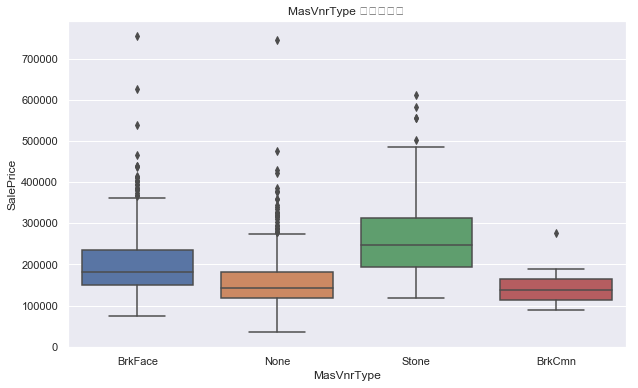

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'ExterQual 与房屋售价')

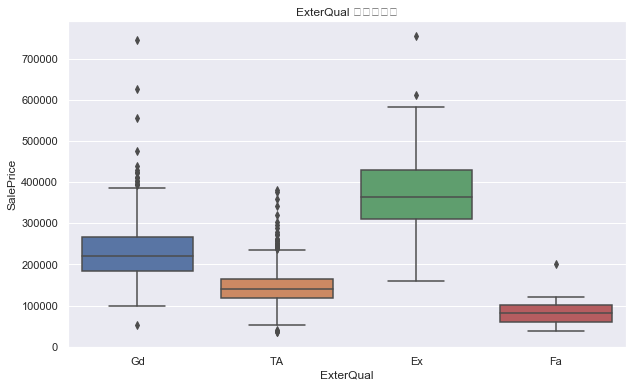

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'ExterCond 与房屋售价')

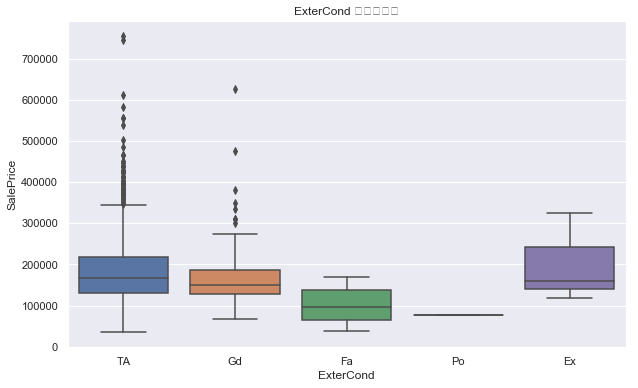

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Foundation 与房屋售价')

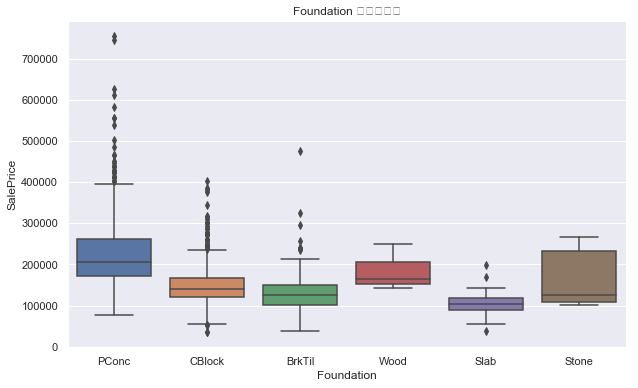

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'BsmtQual 与房屋售价')

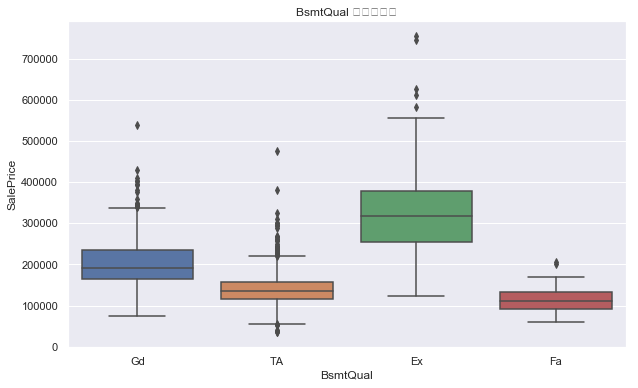

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'BsmtCond 与房屋售价')

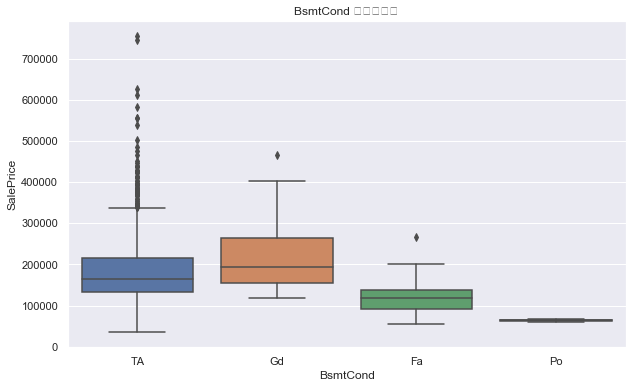

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'BsmtExposure 与房屋售价')

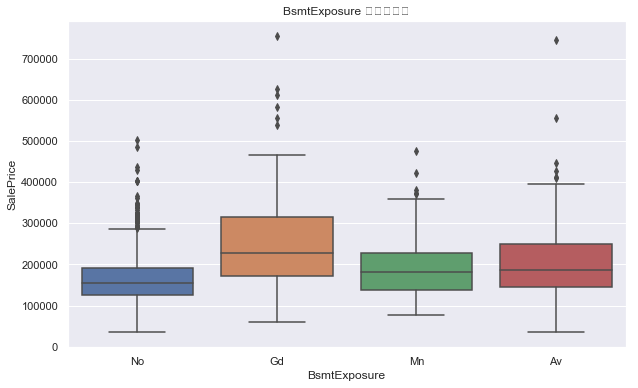

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'BsmtFinType1 与房屋售价')

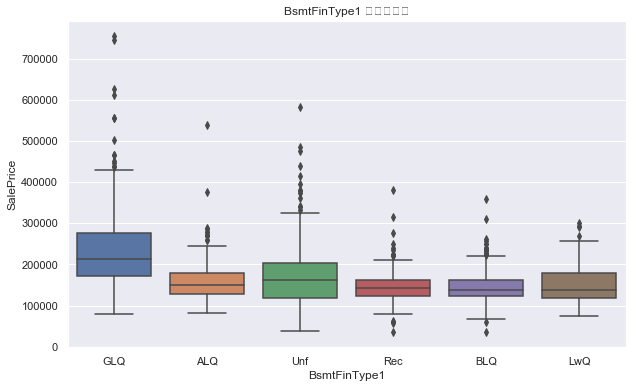

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'BsmtFinType2 与房屋售价')

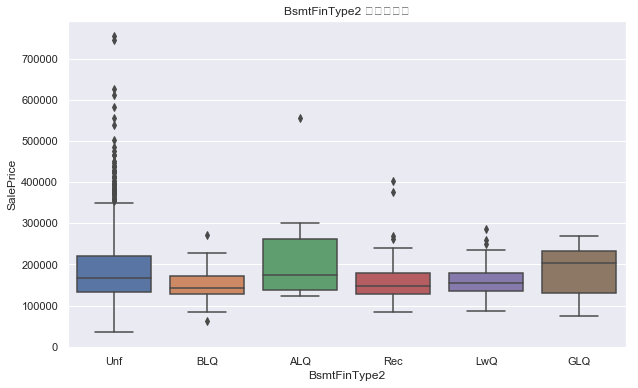

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Heating 与房屋售价')

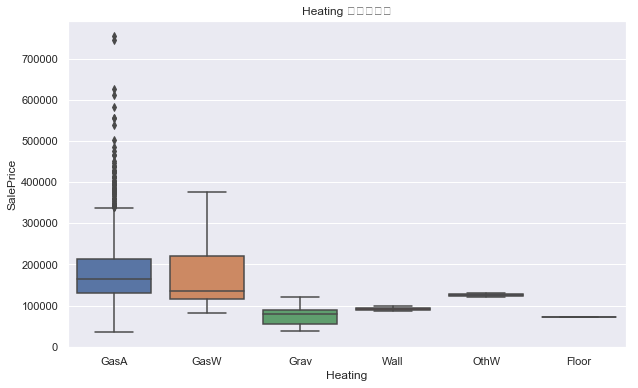

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'HeatingQC 与房屋售价')

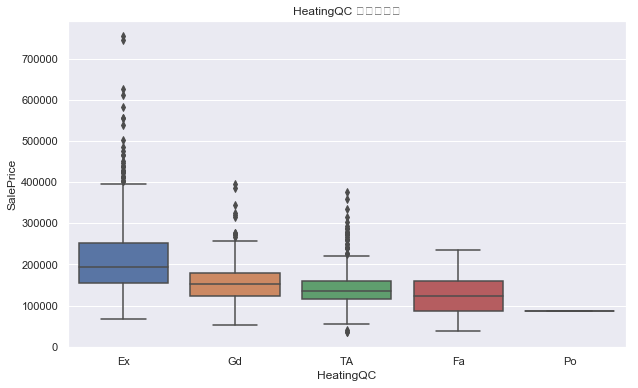

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'CentralAir 与房屋售价')

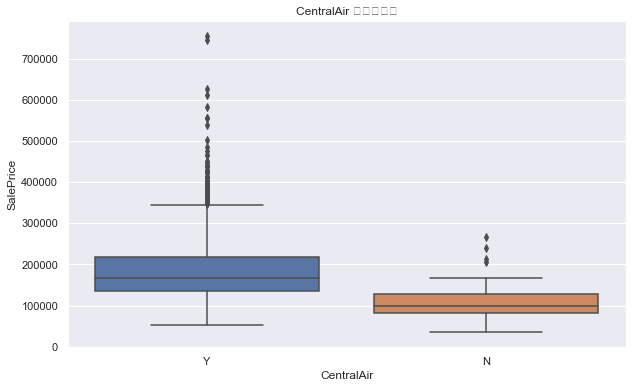

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Electrical 与房屋售价')

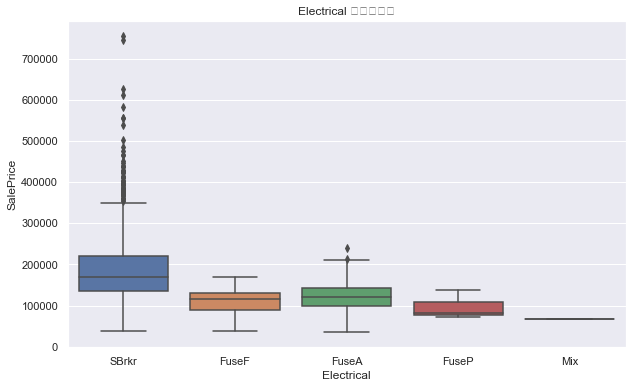

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'KitchenQual 与房屋售价')

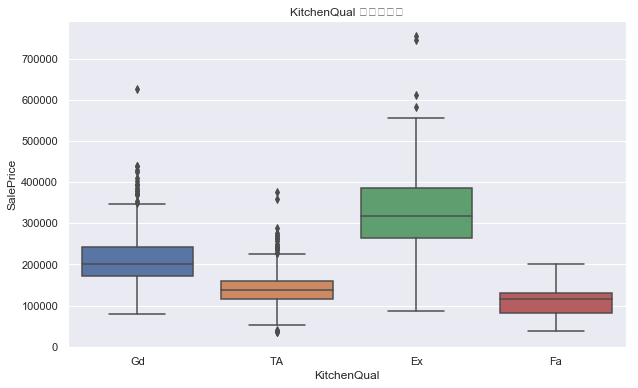

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Functional 与房屋售价')

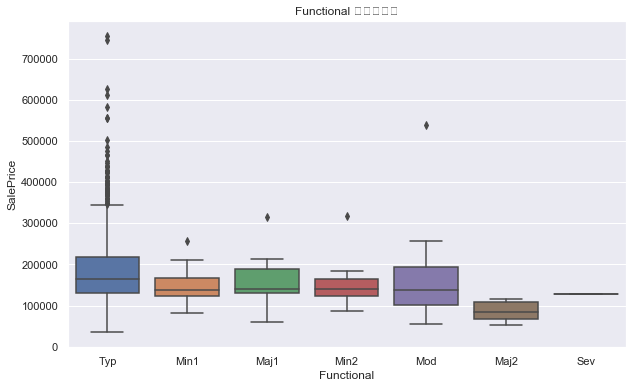

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'FireplaceQu 与房屋售价')

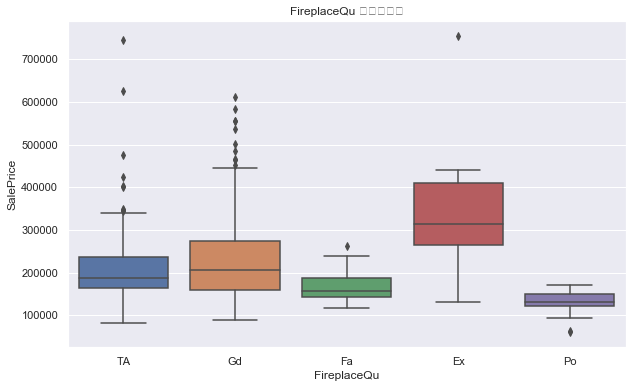

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'GarageType 与房屋售价')

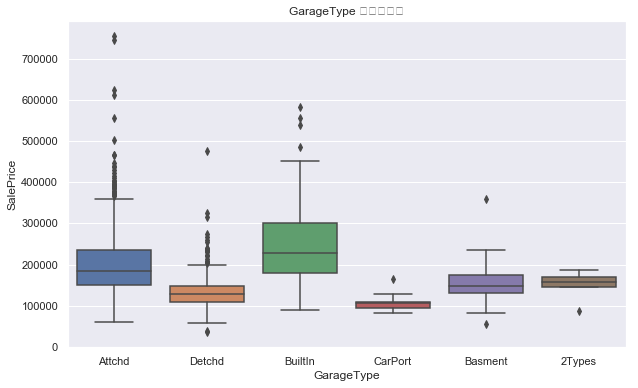

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'GarageFinish 与房屋售价')

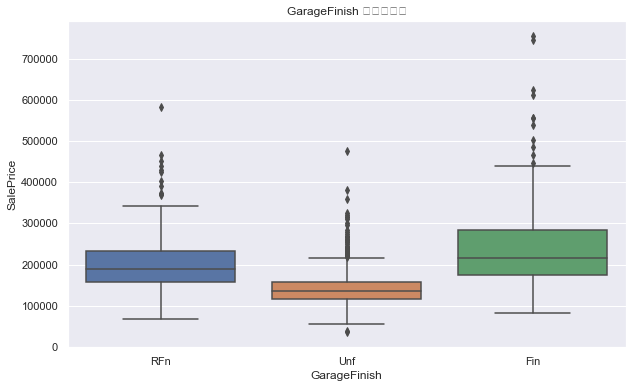

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'GarageQual 与房屋售价')

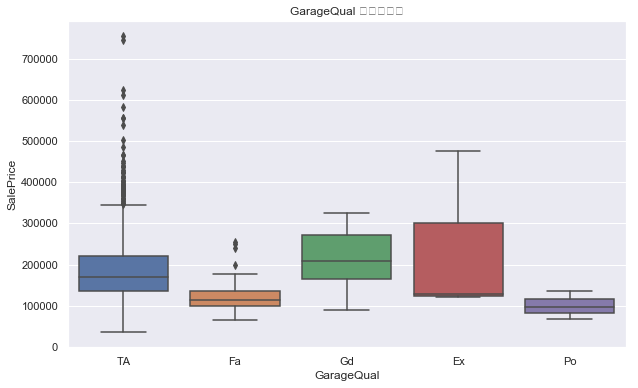

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'GarageCond 与房屋售价')

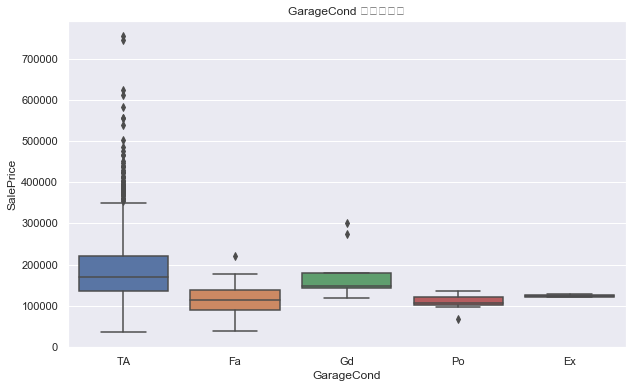

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'PavedDrive 与房屋售价')

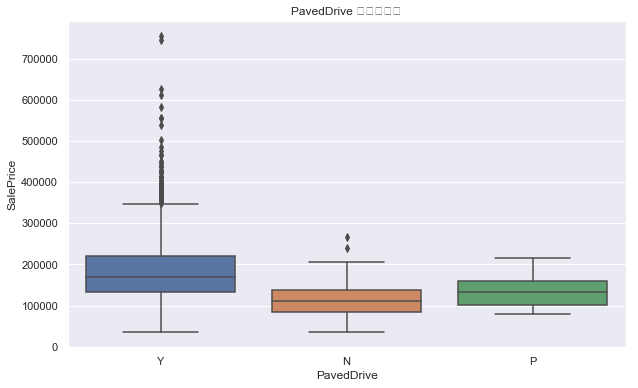

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'PoolQC 与房屋售价')

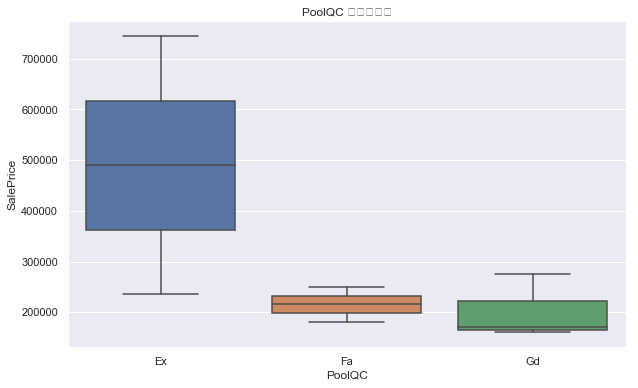

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'Fence 与房屋售价')

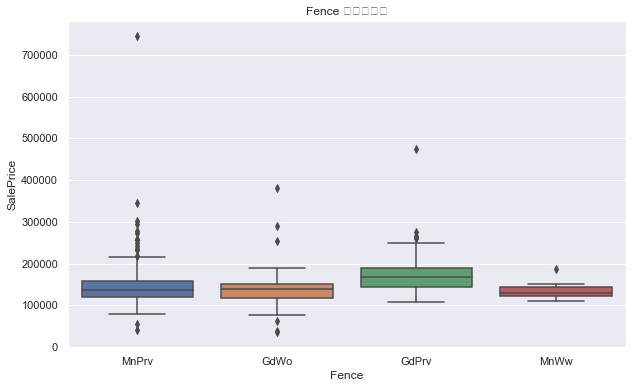

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'MiscFeature 与房屋售价')

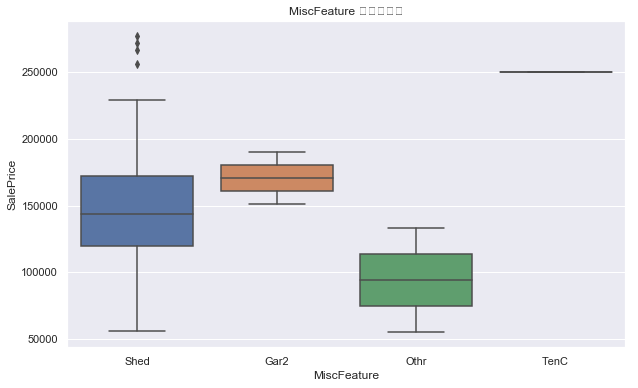

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'SaleType 与房屋售价')

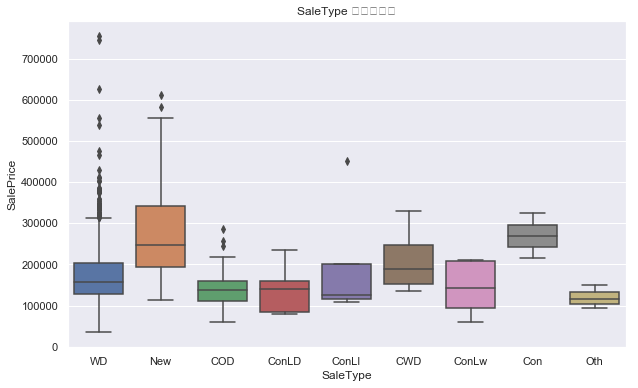

<Figure size 720x432 with 0 Axes>

Text(0.5,1,'SaleCondition 与房屋售价')

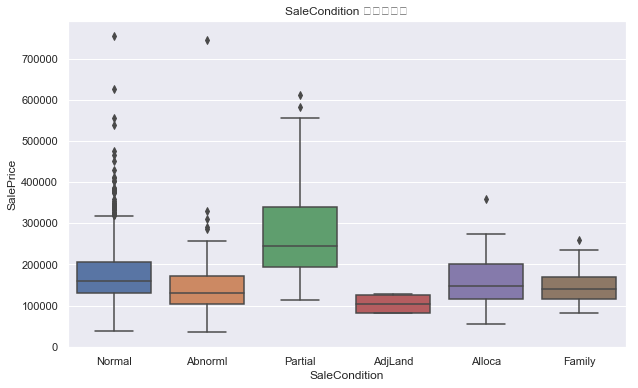

In [17]:
#把类目型变量和目标变量的箱线图/散点图循环画出来，横坐标是类目型变量
for i in full_objectinfo.columns:
    plt.figure(figsize=(10, 6))    #设置画布大小
    sns.boxplot( x=i, y="SalePrice",data=train_df).set_title(i+' 与房屋售价')
    plt.show(); #把画布展示出来


# 数据清洗

## 缺失值

训练集与测试集的缺失值情况

In [18]:
na_df = pd.DataFrame(full_df.isnull().sum(), columns={'missingNum'})
na_df = na_df[na_df.values>0]
na_df['missingRatio'] = na_df['missingNum']/len(full_df)
na_df['trainNum'] = train_df.isnull().sum()
na_df['testNum'] = test_df.isnull().sum()
na_df['dtype'] = full_df.dtypes
na_df.sort_values(by='missingNum',ascending=False)

missingNum  missingRatio  trainNum  testNum    dtype
PoolQC              2909      0.996574      1453   1456.0   object
MiscFeature         2814      0.964029      1406   1408.0   object
Alley               2721      0.932169      1369   1352.0   object
Fence               2348      0.804385      1179   1169.0   object
SalePrice           1459      0.499829         0      NaN  float64
FireplaceQu         1420      0.486468       690    730.0   object
LotFrontage          486      0.166495       259    227.0  float64
GarageCond           159      0.054471        81     78.0   object
GarageYrBlt          159      0.054471        81     78.0  float64
GarageFinish         159      0.054471        81     78.0   object
GarageQual           159      0.054471        81     78.0   object
GarageType           157      0.053786        81     76.0   object
BsmtExposure          82      0.028092        38     44.0   object
BsmtCond              82      0.028092        37     45.0   object
BsmtQual              81      0.027749        37     44.0   object
BsmtFinType2          80      0.027407        38     42.0   object
BsmtFinType1          79      0.027064        37     42.0   object
MasVnrType            24      0.008222         8     16.0   object
MasVnrArea            23      0.007879         8     15.0  float64
MSZoning               4      0.001370         0      4.0   object
Functional             2      0.000685         0      2.0   object
BsmtHalfBath           2      0.000685         0      2.0  float64
BsmtFullBath           2      0.000685         0      2.0  float64
Utilities              2      0.000685         0      2.0   object
KitchenQual            1      0.000343         0      1.0   object
TotalBsmtSF            1      0.000343         0      1.0  float64
BsmtUnfSF              1      0.000343         0      1.0  float64
GarageCars             1      0.000343         0      1.0  float64
GarageArea             1      0.000343         0      1.0  float64
BsmtFinSF2             1      0.000343         0      1.0  float64
BsmtFinSF1             1      0.000343         0      1.0  float64
Exterior2nd            1      0.000343         0      1.0   object
Exterior1st            1      0.000343         0      1.0   object
SaleType               1      0.000343         0      1.0   object
Electrical             1      0.000343         1      0.0   object

查看数据说明发现有的类目型字段空值代表没有通道/泳池/地下室等设施，这部分用"None"填充即可，包括"PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"；<br />

同样地，对于没有这些设施的样本来说，表示面积的数值型字段可以用0填充，包括"MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "BsmtFullBath","BsmtHalfBath", "GarageArea"。<br />

问题：空值不一定代表没有，可能是真的漏记了，比如泳池面积有数值，泳池质量没有值，所以需要先根据相关的特征进行填充，再把空值转为None。（这部分数据比较少先不这么处理比较麻烦）

还有一些类目型字段缺失特别少，不到5个，考虑用众数填充，包括"MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "Functional", "SaleType"。<br />

还有一个数值型字段LotFrontage，缺失值486个，它和LotArea的相关性最强，可以用算法拟合缺失值。

年份数据缺失值 "GarageYrBlt"，可以进行label encode，空值作为none生成一个label数值。

In [19]:
#类目型特征填充None
missing_cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for i in missing_cols1:
    full_df[i].fillna("None", inplace=True)
    
full_df['GarageYrBlt'].fillna(1, inplace=True)

In [20]:
#数值型特征填充0
missing_cols2=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "BsmtFullBath","BsmtHalfBath", "GarageArea"]
for i in missing_cols2:
    full_df[i].fillna(0, inplace=True)

In [21]:
#缺失数量较少的特征用众数填充
missing_cols3=["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "Functional", "SaleType"]
for i in missing_cols3:
    full_df[i].fillna(full_df[i].dropna().mode()[0], inplace=True)

In [22]:
#对LotArea和Neighborhood分组，取中位数填充LotFrontage的缺失值
#由于与房产相连的每条街道的面积很可能与附近的其他房屋面积相似，所以可以通过该社区的LotFrontage中值来填充缺失的值。
full_df["LotAreaCut"] = pd.qcut(full_df.LotArea,10)
full_df.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

full_df['LotFrontage']=full_df.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
full_df['LotFrontage']=full_df.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

full_df.drop("LotAreaCut",axis=1,inplace=True)

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4922.4]    35.741036   34.0   251
(4922.4, 7007.6]      55.460674   52.0   267
(7007.6, 7960.4]      63.008000   62.0   250
(7960.4, 8741.0]      66.964844   65.0   256
(8741.0, 9453.0]      70.106996   70.0   243
(9453.0, 10151.6]     73.972656   75.0   256
(10151.6, 11001.2]    73.650794   75.0   252
(11001.2, 12203.8]    83.377193   82.0   228
(12203.8, 14300.6]    84.991228   85.0   228
(14300.6, 215245.0]   94.188119   90.0   202

## 异常值

在前面的目标和数值型变量的相关图（GrLivArea）可以看出，有两个异常值（面积很大房价却很低，可能是农业用地），可以删除。

In [23]:
import plotly_express as px
px.scatter(full_df,x='GrLivArea',y='SalePrice',hover_name='Id')

In [24]:
full_df = full_df.drop(full_df[(full_df['GrLivArea']>4000) & (full_df['SalePrice']<300000)].index)

# 特征工程

## 增加特征

由于区域相关特征对于确定房价非常重要，这里将增加了一个特征，即每个房屋的地下室总面积，一楼和二楼面积之和

In [25]:
full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['1stFlrSF'] + full_df['2ndFlrSF']

## 特征变换

（1）object类目型特征，大部分可以one-hot，对于代表质量状况的类目型特征，可以转换为顺序型特征，包括。<br />
"PoolQC","HeatingQC","GarageCond","GarageQual","FireplaceQu","KitchenQual","BsmtCond","BsmtQual","ExterCond","ExterQual"

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       

（2）float数值型特征，进行标准化；

（3）int数值型特征，大部分是有数值大小关系可以进行标准化的，除了：<br />
    ①年份特征，包括'YearBuilt', 'YearRemodAdd'改造年份,'GarageYrBlt','YrSold'售卖年份(2006-2010)，可以生成新特征，YrSold-YearBuilt=售卖时的房龄，YearBuilt=YearRemodAdd 则无改造，YrSold-GarageYrBlt=车库库龄；<br />
    ②不代表大小关系而是代表分类的情况，有'MSSubClass'，可以看看跟目标的关系<br />
    ③Id，没啥用可以删掉

### int型特征

In [26]:
#查看int类型的特征有哪些
numerics = ['int16', 'int32', 'int64']
newdf = full_df.select_dtypes(include=numerics)
newdf.columns

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [27]:
#用年份特征生成新特征
full_df['HouseAge']=full_df['YrSold']-full_df['YearBuilt'] #房龄
#full_df['GarageAge']=full_df['YrSold']-full_df['GarageYrBlt'] #车库龄
full_df['IsRemodel']=full_df.apply(lambda x : 'Y' if x['YearBuilt']!=x['YearRemodAdd'] else 'N',axis = 1) #是否改造过


In [28]:
#把下面这些数值型特征转成类目型特征
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full_df[col]=full_df[col].astype(str)

In [29]:
#删除Id列
full_df.drop(['Id'],axis=1, inplace=True)

In [30]:
#将三个年份进行label encode
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

full_df["YearBuilt"]=le.fit_transform(full_df["YearBuilt"])
full_df["YearRemodAdd"]=le.fit_transform(full_df["YearRemodAdd"])
full_df["GarageYrBlt"]=le.fit_transform(full_df["GarageYrBlt"])

In [31]:
#观察MSSubClass和目标的关系，人为进行label encode
#（一种启发式的方法，等于添加了一些先验信息，告诉模型哪些特征取值可以划分为一类，模型可以更好地综合这些信息作判断。）       
full_df['MSSubClass']=full_df['MSSubClass'].replace({180:1, 30:2, 45:2, 190:3, 50:3, 90:3, 85:4, 40:4, 160:4, 70:5, 20:5, 75:5, 80:5, 150:5,120:6,60:6}) 

In [32]:
px.scatter(full_df,x='MSSubClass',y='SalePrice')

### object型特征

In [33]:
# 表示质量的特征进行label encode 并存在新的字段里，原特征也保留让模型自行选择
full_df["oPoolQC"] = full_df.PoolQC.map({'None':1, 'Fa':2, 'Gd':3, 'Ex':4})
full_df["oHeatingQC"] = full_df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_df["oGarageCond"] = full_df.GarageCond.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
full_df["oGarageQual"] = full_df.GarageQual.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
full_df["oFireplaceQu"] = full_df.FireplaceQu.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
full_df["oKitchenQual"] = full_df.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
full_df["oBsmtCond"] = full_df.BsmtCond.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5})
full_df["oBsmtQual"] = full_df.BsmtQual.map({'None':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_df["oExterCond"] = full_df.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_df["oExterQual"] = full_df.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

In [34]:
#新加一些特征（来自特征选择）
full_df["+_TotalHouse_OverallQual"] = full_df["TotalSF"] * full_df["OverallQual"]
full_df["+_GrLivArea_OverallQual"] = full_df["GrLivArea"] * full_df["OverallQual"]
full_df["+_BsmtFinSF1_OverallQual"] = full_df["BsmtFinSF1"] * full_df["OverallQual"]


full_df["-_LotArea_OverallQual"] = full_df["LotArea"] * full_df["OverallQual"]
full_df["-_TotalHouse_LotArea"] = full_df["TotalSF"] + full_df["LotArea"]


full_df["Bsmt"] = full_df["BsmtFinSF1"] + full_df["BsmtFinSF2"] + full_df["BsmtUnfSF"]
full_df["Rooms"] = full_df["FullBath"]+full_df["TotRmsAbvGrd"]
full_df["PorchArea"] = full_df["OpenPorchSF"]+full_df["EnclosedPorch"]+full_df["3SsnPorch"]+full_df["ScreenPorch"]
full_df["TotalPlace"] = full_df["TotalBsmtSF"] + full_df["1stFlrSF"] + full_df["2ndFlrSF"] + full_df["GarageArea"] + full_df["OpenPorchSF"]+full_df["EnclosedPorch"]+full_df["3SsnPorch"]+full_df["ScreenPorch"]

 

### 偏度变换

In [35]:
numeric_features = full_df.dtypes[full_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = full_df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal                21.939672
oPoolQC                20.397039
PoolArea               17.688664
LotArea                13.109495
-_TotalHouse_LotArea   12.172685
-_LotArea_OverallQual  11.682210
3SsnPorch              11.372080
BsmtFinSF2              4.144503
EnclosedPorch           4.002344
ScreenPorch             3.945101

In [36]:
skewness = skewness[abs(skewness) > 0.75]
skewness.drop('SalePrice',inplace=True) #目标变量后面取对数处理
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    full_df[feat] = boxcox1p(full_df[feat], lam)
    
#full_df[skewed_features] = np.log1p(full_df[skewed_features])

There are 48 skewed numerical features to Box Cox transform


### dummies

In [37]:
full_dummies=pd.get_dummies(full_df.drop(['SalePrice'],axis=1))

## RobustScaler

In [38]:
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = RobustScaler()

#full_dummies.drop("HouseAge",axis=1,inplace=True) #如果用log房龄有无穷值（=0的时候）
X = full_dummies[:1458]
Y = full_df.SalePrice[:1458]
X_test = full_dummies[1458:]

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(Y) #数据分布趋近于正态分布

test_X_scaled = scaler.transform(X_test)

In [39]:
#转换成DataFrame
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns=X.columns
X_scaled.index=X.index

test_X_scaled=pd.DataFrame(test_X_scaled)
test_X_scaled.columns=X_test.columns

## 特征选择

In [40]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X.columns)

In [42]:
pd.set_option('display.max_rows', 82)
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance",ascending=False)

Feature Importance
+_TotalHouse_OverallQual        1.260239e-01
Neighborhood_Crawfor            8.517016e-02
TotalPlace                      8.284266e-02
KitchenQual_Ex                  6.487317e-02
BsmtQual_Ex                     6.069687e-02
Functional_Typ                  5.801014e-02
Neighborhood_StoneBr            5.706528e-02
+_GrLivArea_OverallQual         5.354255e-02
GrLivArea                       4.861128e-02
BsmtFinSF1                      4.798461e-02
Exterior1st_BrkFace             4.538411e-02
OverallCond                     4.419114e-02
Neighborhood_BrkSide            4.130410e-02
Condition1_Norm                 4.077114e-02
BsmtExposure_Gd                 3.970361e-02
Neighborhood_NoRidge            3.716698e-02
LotArea                         3.129518e-02
Fireplaces                      2.751173e-02
GarageCars                      2.574742e-02
HalfBath_1                      2.526354e-02
YearBuilt                       2.355582e-02
KitchenAbvGr_1                  2.088955e-02
Neighborhood_NridgHt            2.086852e-02
WoodDeckSF                      1.987950e-02
Foundation_PConc                1.980578e-02
Neighborhood_Somerst            1.486080e-02
oHeatingQC                      1.427630e-02
YearRemodAdd                    1.419832e-02
LotConfig_CulDSac               1.135592e-02
MSZoning_FV                     1.108678e-02
BsmtFinType1_GLQ                1.079549e-02
HeatingQC_Ex                    1.078542e-02
BldgType_1Fam                   1.047508e-02
ExterQual_Ex                    1.018902e-02
SaleType_New                    9.432881e-03
PoolArea                        9.353602e-03
MasVnrType_Stone                8.834150e-03
1stFlrSF                        7.748275e-03
FullBath                        7.068788e-03
PavedDrive_Y                    6.296767e-03
MoSold_5                        6.150232e-03
oExterQual                      6.120401e-03
Exterior1st_MetalSd             5.905670e-03
SaleCondition_Normal            4.995092e-03
-_LotArea_OverallQual           4.635015e-03
oKitchenQual                    4.467838e-03
ScreenPorch                     3.540489e-03
BedroomAbvGr_2                  2.798430e-03
MoSold_7                        2.784256e-03
MSSubClass_20                   2.513827e-03
LotFrontage                     3.460039e-04
CentralAir_Y                    4.305379e-15
Bsmt                           -1.541222e-04
LotConfig_Inside               -1.537383e-03
GarageFinish_Unf               -1.605134e-03
MiscVal                        -1.606626e-03
BsmtFinSF2                     -1.738271e-03
BsmtFinType1_Rec               -2.430497e-03
ExterCond_Gd                   -3.776662e-03
Foundation_BrkTil              -4.053487e-03
KitchenQual_TA                 -5.387480e-03
BsmtQual_TA                    -5.592060e-03
BedroomAbvGr_3                 -5.690880e-03
HeatingQC_TA                   -5.937391e-03
YrSold_2009                    -6.040147e-03
TotalBsmtSF                    -6.045427e-03
MSSubClass_30                  -6.530733e-03
Exterior1st_Wd Sdng            -6.565751e-03
GarageCond_Fa                  -6.862599e-03
Neighborhood_Mitchel           -7.831013e-03
BsmtExposure_No                -1.067423e-02
BsmtUnfSF                      -1.158548e-02
SaleType_WD                    -1.214713e-02
ExterQual_TA                   -1.415746e-02
BsmtFullBath_0.0               -1.829144e-02
CentralAir_N                   -2.029955e-02
Neighborhood_Edwards           -2.120896e-02
KitchenAbvGr_2                 -2.230142e-02
MSZoning_RM                    -3.790015e-02
SaleCondition_Abnorml          -5.672699e-02
HouseAge                       -6.617830e-02
MSZoning_C (all)               -1.904497e-01

(array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15]),
 <a list of 9 Text xticklabel objects>)

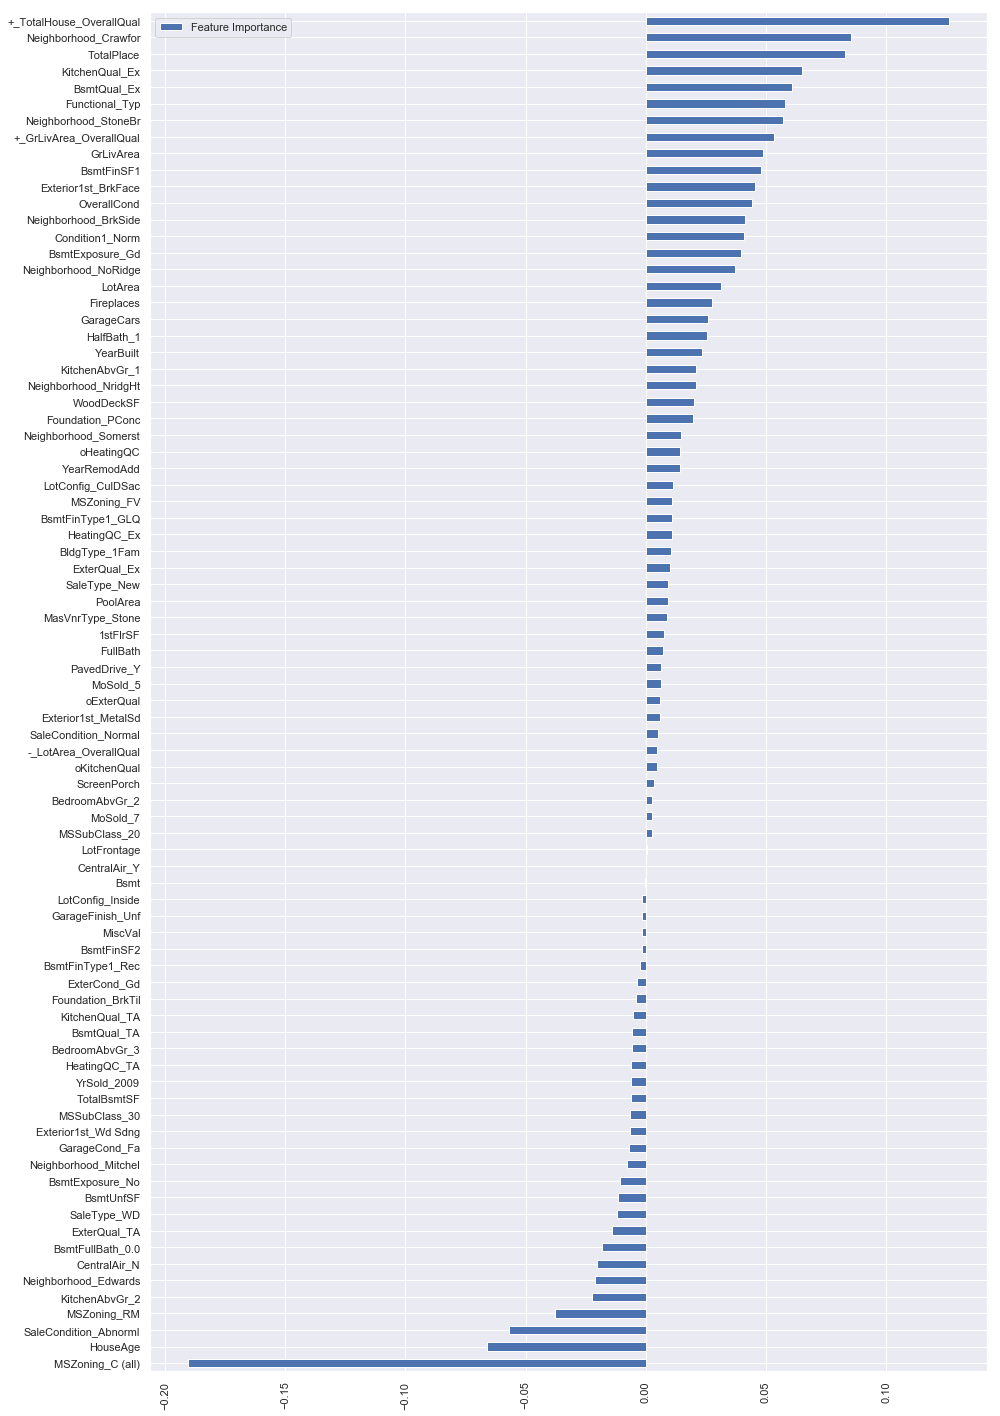

In [43]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

## PCA

In [44]:
X_scaled.shape

(1458, 406)

In [45]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(n_components=390)

X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)
X_scaled.shape, test_X_scaled.shape

((1458, 390), (1459, 390))

# 建模&评估

In [46]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
def rmse_cv(model,X,y):
    '''5折交叉验证的均方根误差'''
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor


## 基本模型

In [48]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]

for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 10373523269.887890, 6142444105.3481
Ridge: 0.119597, 0.0092
Lasso: 0.133985, 0.0045
RF: 0.166815, 0.0073
GBR: 0.141293, 0.0055
SVR: 0.119871, 0.0078
LinSVR: 0.121853, 0.0105
Ela: 0.114905, 0.0063
SGD: 0.168113, 0.0163
Bay: 0.114027, 0.0069
Ker: 0.112847, 0.0061
Extra: 0.157266, 0.0083
[17:05:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Anaconda2\envs\py3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

D:\Anaconda2\envs\py3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[17:06:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Anaconda2\envs\py3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[17:06:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Anaconda2\envs\py3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[17:06:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Anaconda2\envs\py3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[17:06:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgb: 0.140826, 0.0064


## 调参

In [49]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

grid是类名，传入model参数，grid_get是方法，这个函数可以fit之后(选择最优超参数)打印出5折交叉验证最优参数和平均score、各个参数5折交叉验证的平均score和平均std

In [50]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0004, 'max_iter': 10000} 0.1142737237959018
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.114274        0.001471
1  {'alpha': 0.0005, 'max_iter': 10000}         0.115009        0.001458
2  {'alpha': 0.0007, 'max_iter': 10000}         0.116742        0.001430
3  {'alpha': 0.0006, 'max_iter': 10000}         0.115912        0.001438
4  {'alpha': 0.0009, 'max_iter': 10000}         0.117739        0.001436
5  {'alpha': 0.0008, 'max_iter': 10000}         0.117345        0.001423


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default

In [51]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 35} 0.1142723016128973
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.114272        0.001457
1  {'alpha': 40}         0.114391        0.001450
2  {'alpha': 45}         0.114521        0.001445
3  {'alpha': 50}         0.114659        0.001442
4  {'alpha': 55}         0.114802        0.001439
5  {'alpha': 60}         0.114948        0.001437
6  {'alpha': 65}         0.115097        0.001435
7  {'alpha': 70}         0.115247        0.001434
8  {'alpha': 80}         0.115550        0.001432
9  {'alpha': 90}         0.115854        0.001431


D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default

In [52]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 14, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.11091804191683294
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.111195   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.111021   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.111192   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.111029   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.111161   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.111027   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.111126   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.110999   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.111110   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.110988   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.111076   
11  {'C': 13, 'epsilon': 0.009

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default

In [53]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.1113694948081144
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.112035   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.111437   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.111422   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.112794   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.111693   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.111369   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.113656   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.112119   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.111559   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.114548   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.112598   
11  {'alpha': 0.5, 'coef0':

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default

In [54]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter': 10000} 0.1139031879825697
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.119135   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.118656   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.114925   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.113914   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.114078   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.117140   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.116560   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.113903   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.114341   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.115579   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.114283   
11  {'alpha': 0.004, 'l1_ratio': 0.1, '

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default

## 加权平均

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [ ]:
ker = KernelRidge(alpha=0.3 ,kernel='polynomial',degree=3 , coef0=1.2) # 0.1113694948081144
bay = BayesianRidge() #0.114027
ela = ElasticNet(alpha=0.0008,l1_ratio=0.3,max_iter=10000) # 0.1139031879825697
ridge = Ridge(alpha=35) # 0.1142723016128973
svr = SVR(gamma= 0.0004,kernel='rbf',C=14,epsilon=0.009) # 0.11091804191683294
lasso = Lasso(alpha=0.0004,max_iter=10000)  # 0.1142737237959018

w1 = 0.3
w2 = 0.2
w3 = 0.2
w4 = 0.1
w5 = 0.1
w6 = 0.1


weight_avg = AverageWeight(mod = [svr,ker,ela,bay,ridge,lasso],weight=[w1,w2,w3,w4,w5,w6])
rmse_cv(weight_avg,X_scaled,y_log),  
rmse_cv(weight_avg,X_scaled,y_log).mean()


(array([0.10474051, 0.11622679, 0.11967686, 0.10132054, 0.11019835]),)

In [ ]:
weight_avg = AverageWeight(mod = [ker,svr],weight=[0.5,0.5])
rmse_cv(weight_avg,X_scaled,y_log),  
rmse_cv(weight_avg,X_scaled,y_log).mean()
# 线上：0.11321
# 交叉验证：0.10949995320199449

## 预测

In [ ]:
weight_avg.fit(X_scaled,y_log)

Y_pred = np.exp(weight_avg.predict(test_X_scaled))


submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": Y_pred
    })
submission.to_csv('D:/myprograms/HousePrice/submission/AverageWeight13.csv', index=False)